# The main script

As mentioned in the readme the main steps are as follow: 

1. Download the data.
2. Read the data and some initial data exploration.
3. Clean the training data.
4. Train the PLSR model using cleaned data and two different feature selection methods.
5. Apply the model with better performance on the hyperspectral image to create the percent nitrogen map.


## First import the main modules 

In [14]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))
import numpy as np
import matplotlib.pylab as plt
import xarray as xr
import rioxarray as rxr
import pandas as pd
import pickle
# The followings were developed specifically for this project
from src.models.earhlab_lib import hyper_plsr
from src.features import build_features
from src.data.make_dataset import gdown_file

## 1. Download the data including a csv file and the hyperspectral image

In [15]:
from src.data.make_dataset import gdown_file
url_tif = "https://drive.google.com/uc?id=1UOEeyzHW-h0el2Qzk1o7BiSsqT8f8ax2"
url_tfw = "https://drive.google.com/uc?id=1I3Ns7sQ4ETFVsYD6sEQXzR65xHtyFIfD"
url_csv = "https://drive.google.com/uc?id=1XZMnMvglfqABTA3oVaJGUM3X-qV1uOqa"
gdown_file(url_tif,"../data/raw/hyper_image.tif")
gdown_file(url_tfw, "../data/raw/hyper_image.tfw")
gdown_file(url_csv, "../data/raw/Data.csv")
print("Download completed!")


Downloading...
From: https://drive.google.com/uc?id=1UOEeyzHW-h0el2Qzk1o7BiSsqT8f8ax2
To: /data/home/hamiddashti/mnt/nasa_above/earthlab/data/raw/hyper_image.tif
479MB [00:05, 93.8MB/s]
[Errno 2] No such file or directory: '../data/raw/hyper_image.tif'
Downloading...
From: https://drive.google.com/uc?id=1I3Ns7sQ4ETFVsYD6sEQXzR65xHtyFIfD
To: /data/home/hamiddashti/mnt/nasa_above/earthlab/data/raw/hyper_image.tfw
100%|██████████| 222/222 [00:00<00:00, 198kB/s]
Downloading...
From: https://drive.google.com/uc?id=1XZMnMvglfqABTA3oVaJGUM3X-qV1uOqa
To: /data/home/hamiddashti/mnt/nasa_above/earthlab/data/raw/Data.csv
100%|██████████| 624k/624k [00:00<00:00, 4.23MB/s]

Download completed!


## 2. Read the data and perform some data exploration

In [16]:
# Read the csv (training) data
csv_data = pd.read_csv("../data/raw/Data.csv")
# Read the hyperspectral image
hyper_img = rxr.open_rasterio("../data/raw/hyper_image.tif")
# Make the band number to start with 0 to make it coonsistent with python indexing
hyper_img["band"] = hyper_img["band"] - 1

In [17]:
# CSV file content, the first column is measured nitrogen in percent and other 
# columns are the reflectance values for different spectral bands
print(csv_data)

     nitrogen  381.36026  386.368927  391.377594  396.386292  401.394958  \
0         NaN  -0.015750   -0.000410    0.002750    0.010720    0.010480   
1         NaN  -0.025010   -0.011980   -0.010180   -0.003490   -0.003820   
2         NaN  -0.010730    0.008020    0.011260    0.020860    0.021050   
3         NaN  -0.008530    0.008100    0.010440    0.018360    0.016780   
4    1.223945  -0.020460   -0.005830   -0.002950    0.004900    0.004650   
..        ...        ...         ...         ...         ...         ...   
191  2.166600   0.005535    0.052470    0.058871    0.070103    0.072897   
192  2.408300   0.003750    0.047256    0.053006    0.063522    0.065950   
193  2.600000   0.007845    0.058672    0.063979    0.076104    0.079309   
194       NaN   0.007469    0.057818    0.064453    0.075616    0.079102   
195  2.400000   0.005595    0.053338    0.058369    0.069548    0.072299   

     406.403625  411.412292  416.420959  421.429626  ...  2459.958252  \
0      0.01713

In [18]:
# Note that the image is an xarray object
print(hyper_img)

<xarray.DataArray (band: 373, y: 559, x: 572)>
[119266004 values with dtype=float32]
Coordinates:
  * band         (band) int64 0 1 2 3 4 5 6 7 ... 366 367 368 369 370 371 372
  * x            (x) float64 3.939e+05 3.939e+05 ... 3.945e+05 3.945e+05
  * y            (y) float64 4.05e+06 4.05e+06 4.05e+06 ... 4.05e+06 4.05e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


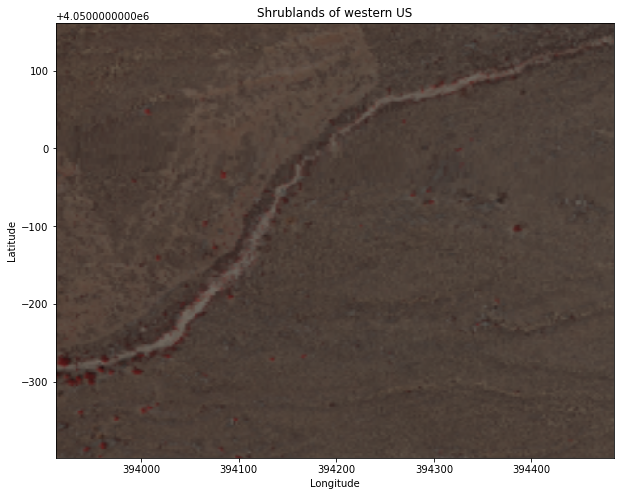

In [19]:
# plot the false color composite of the image: 
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
hyper_img.isel(band=[104,62,42]).plot.imshow(ax=ax)
ax.set_title("Shrublands of western US")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# Save the figure
plt.savefig("../reports/figures/CIR_image.png")



## 3. Cleaning the training data (csv file):
1. Remove observations with nan values (no nitrogen measured).
2. Remove the columns with negative reflectance.
3. Remove water absorption bands.    

In [22]:
# Clean CSV file
X, y, non_negative_columns, water_bands, wl = build_features.clean_data(csv_data)
cleaned_csv =np.c_[y, X]
cols = [str(wl[i]) for i in range(len(wl))]
cols.insert(0,"Nitrogen[%]")
cleaned_csv_pd = pd.DataFrame(cleaned_csv,index=None, columns=cols)
cleaned_csv_pd.to_csv("../data/processed/cleaned_csv.csv",index=False)

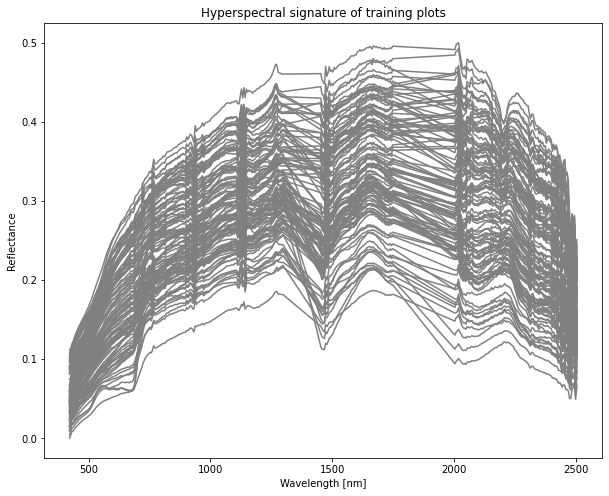

In [23]:
# plot the spectra in the training set:
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
plt.plot(wl,X.T,color="gray")
ax.set_title("Hyperspectral signature of training plots")
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Reflectance")
plt.savefig("../reports/figures/spectral_bands.png")


## 4. Train the plsr model usign two different feature selections techniques
Our goal is to optimize for both model complexity (number of components) and optimal features. 

* The first technique is based on Variable Importance Projection (VIP). The procedure is as follow: 

    - Fit a model with all features for each model with 1 component.
    - Calculate the VIP values for the fitted model.
    - Select features with VIP values greater than 1.
    - Fit the model with selected features and calculate/save error (MSE).
    - Increased the number of component by 1 (up to 15) and repeat the procedure.

We call the model based on this ml_vip. 


* The second technique is based on removing the spectral bands that have small
coeeficient after fitting the regression. The procedure is as follow:
    - Fit a model with all components

In [25]:
# Fit the vpn plsr model
vip_model = hyper_plsr()
vip_model.plsr_vip(X, y, max_comp=15)

# Fit the variable selection method (It may take a few minutes)
vs_model = hyper_plsr()
vs_model.plsr_vs(X, y, 15)


In [26]:
# Save the models as pickle object to disk
pickle.dump(vip_model.model, open("../models/vip_model.pkl", 'wb'))
pickle.dump(vs_model.model, open("../models/vs_model.pkl", 'wb'))

# To reload the model uncomment the following line:
# vip_model = pickle.load(open(../models/vip_model.pkl, 'rb'))
# vs_model = pickle.load(open(../models/vip_model.pkl, 'rb'))

## Lets take a look at the scores of fitted models using both approach

In [27]:
print(
    (
        f"VIP model calibration r2 and rmse:{np.round(ml1.scores[0],2)},"
        f" {np.round(ml1.scores[2],2)}."
        f"\nVIP model cross calibration r2 and rmse:{np.round(ml1.scores[1],2)},"
        f" {np.round(ml1.scores[3],2)}.\n"
        f"VS model calibration r2 and rmse:{np.round(ml2.scores[0],2)},"
        f" {np.round(ml2.scores[2],2)}."
        f"\nVS model cross calibration r2 and rmse:{np.round(ml2.scores[1],2)},"
        f" {np.round(ml2.scores[3],2)}.\n"
    )
)

VIP model calibration r2 and rmse:0.54, 0.07.
VIP model cross calibration r2 and rmse:0.33, 0.11.
VS model calibration r2 and rmse:0.76, 0.04.
VS model cross calibration r2 and rmse:0.51, 0.08.



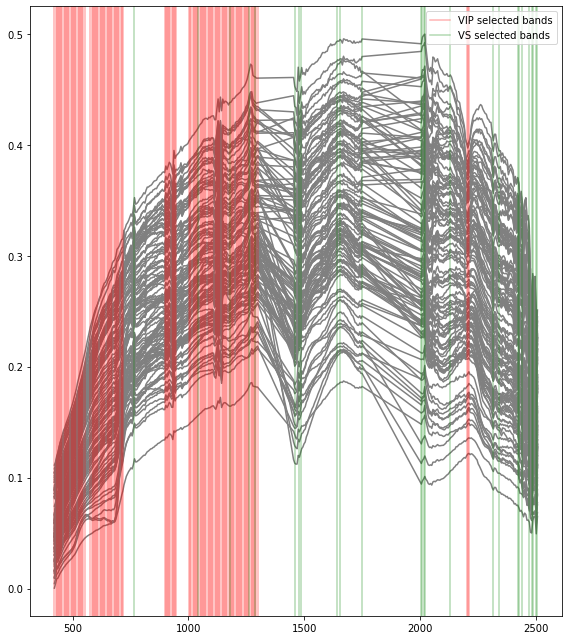

In [28]:

# Ploting the selected bands
plt.close()
fig, ax = plt.subplots(figsize=(8, 9))
ax.plot(wl, X.T, color="gray")
selected_wl_vip = wl[ml1.selected_index]

[
    plt.axvline(
        x=selected_wl_vip[i], color="red", alpha=0.3, label="VIP selected bands"
    )
    for i in range(len(selected_wl_vip))
]

selected_wl_vs = wl[ml2.sorted_ind[ml2.wav :]]
[
    plt.axvline(
        x=selected_wl_vs[i], color="green", alpha=0.3, label="VS selected bands"
    )
    for i in range(len(selected_wl_vs))
]
handles, labels = plt.gca().get_legend_handles_labels()
temp = {k: v for k, v in zip(labels, handles)}
plt.legend(temp.values(), temp.keys(), loc="best")
plt.tight_layout()
plt.savefig("../reports/figures/selected_bands.png")

As you can see compare to VIP band selection, the simple variable selection (VS model) led to better calibratio and validation results. 

In [29]:
# Apply VS model to the image 

hyper_img = hyper_img.isel(band=non_negative_columns)
hyper_img = hyper_img.drop(water_bands, dim="band")
img_sorted = hyper_img[ml2.sorted_ind, :, :]
img_selected = img_sorted[ml2.wav :, :, :]
print(img_selected)

<xarray.DataArray (band: 26, y: 559, x: 572)>
[8313448 values with dtype=float32]
Coordinates:
  * band         (band) int64 237 339 275 234 271 132 ... 359 372 371 367 368
  * x            (x) float64 3.939e+05 3.939e+05 ... 3.945e+05 3.945e+05
  * y            (y) float64 4.05e+06 4.05e+06 4.05e+06 ... 4.05e+06 4.05e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


In [31]:
nitrogen_map = hyper_plsr.xr_predict(img_selected, vs_model.model, "band")

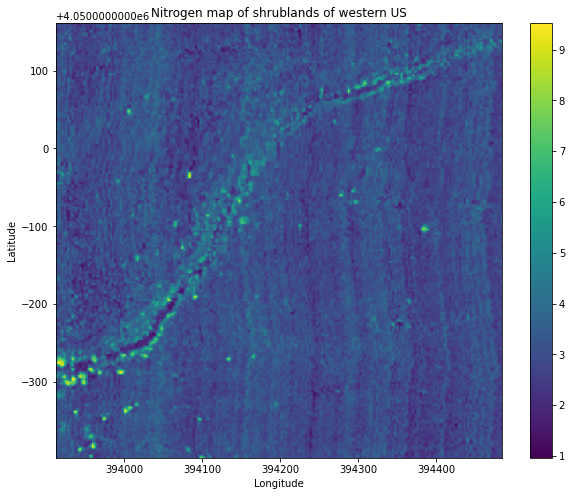

In [32]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
nitrogen_map.plot()
ax.set_title("Nitrogen map of shrublands of western US")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.savefig("../reports/figures/nitrogen_map.png")